In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
import json
import sys
import os
import matplotlib
#matplotlib.use('Agg') 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
import pdb
import ipdb
import h5py
import importlib
import pickle

# Add root folder to sys path
sys.path.append("../")

# %pylab inline
# inline doesn't give interactive plots
%matplotlib inline 
# %matplotlib notebook
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Blues'

sns.set()

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Import own modules
# Need to use importlib since module starts with a numerical value.

from load_expert_traj import Expert, ExpertHDF5
from grid_world import create_obstacles

plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots

/home/mohit/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_data_n_colors_policy(data, grid_size, policy,
                              bounds=[-100, -0.5, 0.5, 1000],
                              color_map=['black', 'grey', 'red'],
                              save_path=''):
    
    cmap = matplotlib.colors.ListedColormap(color_map)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(data, cmap=cmap, norm=norm, extent=[0, grid_size, 0, grid_size],
              )

    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.grid(True)
    ax.autoscale(enable=False)

    for a, m in [(0, '>'), (1, 'v'), (2, '<'), (3, '^')]:
        if len(np.where(policy == a)) > 0:
            x, y = np.where(policy == a)
            # Why this weird math?
            # Original grid map has origin at top left (usual for images).
            # imshow (above) has a property `extent` which allows us to define the origin
            # location when rendering. But ax.scatter (below) doesn't have such an API,
            # it rather defines origin at  bottom left corner hence to convert to top left
            # we do the below math.
            ax.scatter(x=y + 0.5, y=grid_size - 1 - x + 0.5, c='r',
                       s=120, marker=m, edgecolors='none')
    if len(save_path) > 0:
        fig.savefig(save_path)
        
    fig.show()
    
def plot_trajectory(traj_data, grid_size,
                    pred_traj_data=None,
                    obstacles=None,
                    rooms=None,
                    bounds=[-100, -.5, .5, 100],
                    color_map=['black', 'grey', 'red'],
                    save_path='', figsize=(6,6)):
    cmap = matplotlib.colors.ListedColormap(color_map)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    img_arr = np.ones(grid_size)
    if obstacles is not None:
        for o in obstacles:
            img_arr[o[0], o[1]] = 0.0
    ax.imshow(img_arr, 
              cmap=cmap,
              norm=norm,
              extent=[0, grid_size[1], 0, grid_size[0]],
              interpolation='none', aspect='equal', origin='lower',
              )

    ax.set_xticks(range(grid_size[0]))
    ax.set_yticks(range(grid_size[1]))
    ax.grid(True)    

    pdb.set_trace()
    print(traj_data)
    for i in range(traj_data.shape[0]):
        x, y = traj_data[i, 0], traj_data[i, 1]
        marker = '.' if i > 0 else '*'
        ax.scatter(x=x + 0.5, y=y + 0.5, c='r',
                       s=120, marker=marker, edgecolors='none')
        
        if pred_traj_data is not None:
            pred_x, pred_y = pred_traj_data[i, 0], pred_traj_data[i, 1]
            ax.scatter(x=pred_x, y=pred_y + 0.75, c='g',
                       s=120, marker=marker, edgecolors='none')

    if len(save_path) > 0:
        fig.savefig(save_path)
    
    fig.tight_layout()
    fig.show()
    
def softmax(x):
    new_x = x - np.max(x,axis=1)[:, np.newaxis]
    denom = np.sum(np.exp(new_x), axis = 1)[:, np.newaxis]
    return np.exp(new_x)/denom

> <ipython-input-2-9c681b9bff36>(63)plot_trajectory()
-> print(traj_data)
(Pdb) c
[[3. 3.]
 [3. 4.]
 [3. 5.]
 [3. 6.]
 [3. 7.]
 [4. 7.]
 [5. 7.]
 [6. 7.]
 [7. 7.]
 [7. 6.]]


/home/mohit/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


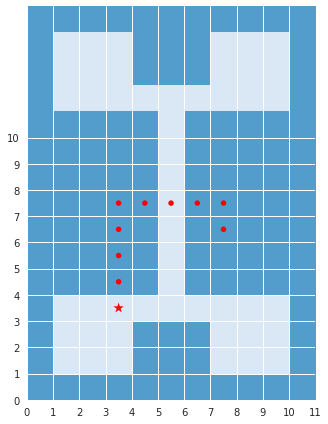

In [3]:
def get_all_trajectory_from_sequence(states):
    states_int = states.astype(int)

    last_goal_idx = 0
    traj_list = []
    while last_goal_idx < states.shape[0]:
        curr_goal_idx = last_goal_idx
        while curr_goal_idx < states.shape[0]:
            if (states_int[last_goal_idx, 2:].tolist()
                == states_int[curr_goal_idx, 2:].tolist()):
                curr_goal_idx = curr_goal_idx + 1
            else:
                break
        # we have one trajectory
        traj = states[last_goal_idx:curr_goal_idx, :]
        traj_list.append(traj)
        last_goal_idx = curr_goal_idx
        
    return traj_list


def plot_expert_trajectories_from_h5(expert_h5_path,
                                     num_traj_to_plot=10,
                                     obstacles=None,
                                     rooms=None):
    expert = ExpertHDF5(expert_h5_path, 2)
    # Push data into memory
    expert.push()
    
    expert_data = expert.sample(num_traj_to_plot)
    
    i = 0
    while i < num_traj_to_plot:
        ep_states = expert_data.state[i]
        traj_list = get_all_trajectory_from_sequence(ep_states)
        for traj in traj_list:        
            # get (x, y) states for trajectories
            ep_positions = traj[:, :2][::-1]
            # Plot trajectory
            plot_trajectory(ep_positions,
                            (15, 11),
                            color_map=sns.color_palette("Blues_r"),
                            figsize=(6, 6),
                            obstacles=obstacles,
                            rooms=rooms)
            i = i + 1
            if i >= num_traj_to_plot:
                break

obstacles, rooms = create_obstacles(15, 11, env_name='room',
                                    room_size=3)
plot_expert_trajectories_from_h5('../h5_trajs/room_trajs/',
                                 num_traj_to_plot=1,
                                 obstacles=obstacles,
                                 rooms=rooms,
                                 )
